In [10]:
import cv2
import re
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import tensorflow as tf
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Bidirectional,BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score

In [11]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, holistic_model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = holistic_model.process(image)        # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def extract_keypoints(results):
    if results.right_hand_landmarks:
        rh = np.array([[res.x, res.y] for res in results.right_hand_landmarks.landmark])
    else:
        rh = np.zeros((21, 2))  
    return rh


def draw_styled_landmarks(image, results):
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [12]:
def normalize_keypoints(keypoints):
    # Kiểm tra nếu có đủ số điểm (21 điểm cho mỗi bàn tay)
    if keypoints.shape[0] != 21:
        raise ValueError(f"Số lượng điểm keypoints không hợp lệ: {keypoints.shape[0]}")

    # Cổ tay là điểm đầu tiên trong keypoints (index 0)
    wrist = keypoints[0]
    
    # Dịch các điểm sao cho cổ tay trở thành gốc tọa độ (0, 0)
    normalized_keypoints = []
    for point in keypoints:
        normalized_point = (point[0] - wrist[0], point[1] - wrist[1])  # Chỉ cần dịch x, y
        normalized_keypoints.append(normalized_point)
    
    normalized_keypoints = np.array(normalized_keypoints)
    
    x_min, y_min = np.min(normalized_keypoints, axis=0)
    x_max, y_max = np.max(normalized_keypoints, axis=0)
    
    if (x_max - x_min) == 0:
        print("Cảnh báo: Tọa độ x không thay đổi, bỏ qua chuẩn hóa x.")
        x_min, x_max = 0, 1  # Cứ để giá trị x giữ nguyên, hoặc chọn giá trị mặc định
    if (y_max - y_min) == 0:
        print("Cảnh báo: Tọa độ y không thay đổi, bỏ qua chuẩn hóa y.")
        y_min, y_max = 0, 1  # Cứ để giá trị y giữ nguyên, hoặc chọn giá trị mặc định
    
    min_vals = np.array([x_min, y_min])
    max_vals = np.array([x_max, y_max])
    
    normalized_keypoints = (normalized_keypoints - min_vals) / (max_vals - min_vals)
    
    return normalized_keypoints

In [13]:
def process_npy(action):    
    # Khởi tạo mô hình Mediapipe Holistic
    with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
        
        # Lấy danh sách tất cả video trong thư mục của action cụ thể
        video_folder = f'data/{action}'
        videos = [f for f in os.listdir(video_folder) if f.endswith('.avi')]
        
        for videoCounter, videoFile in enumerate(videos):
            cap = cv2.VideoCapture(os.path.join(video_folder, videoFile))
            framesCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            points = []
            # Không cần skip frame nữa, xử lý tất cả frame
            for frameCounter in range(framesCount):  # Xử lý tất cả các frame trong video
                ret, frame = cap.read()
                
                if not ret:
                    break  # Nếu không đọc được frame thì dừng
                
                # Chạy Mediapipe để phát hiện landmarks
                image, results = mediapipe_detection(frame, holistic)
                
                # Hiển thị kết quả (có thể bỏ qua nếu không cần thiết)
                # cv2.imshow('OpenCV Feed', image)
                
                # Trích xuất keypoints từ kết quả Mediapipe
                keypoints = normalize_keypoints(extract_keypoints(results))
                
                #  Tạo thư mục để lưu các keypoints của video và frame hiện tại
                npy_dir = os.path.join('data_npy', action, str(videoCounter))
                os.makedirs(npy_dir, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại
            
                npy_path = os.path.join('data_npy', action, str(videoCounter), str(frameCounter))
                np.save(npy_path, keypoints)
                
                # Nếu nhấn 'q', thoát khỏi quá trình xử lý
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
            
            # Giải phóng tài nguyên video sau khi xử lý xong
            cap.release()
    
    # Đóng tất cả cửa sổ OpenCV
    cv2.destroyAllWindows()

In [14]:
# process_npy('chop')

In [15]:
current_directory = os.getcwd()
print("Thư mục hiện hành là:", current_directory)

Thư mục hiện hành là: d:\Phong\Coding\HandTracking\interaction


In [16]:
classes = ['idle', 'chop', 'pinch']

label_map = {label:num for num, label in enumerate(classes)}
label_map

{'idle': 0, 'chop': 1, 'pinch': 2}

In [17]:
# data = np.load('data_npy/left/289.npy')
# print(data)

In [18]:
def create_dataset():   
    sequences, labels = [], []    
    for action in classes:
        
        # Lấy danh sách tất cả video trong folder của action cụ thể
        video_folder = f'data_npy/{action}'
        videos = sorted([f for f in os.listdir(video_folder) if os.path.isdir(os.path.join(video_folder, f))], key=lambda x: int(x))
        
        # Lặp qua tất cả video trong folder
        for sequence in videos:
            print(sequence)
            window = []
            for frame_num in range(15):  # Giả định rằng mỗi video có n frame cần xử lý
                # Đọc file numpy của từng frame
                print(f'{action}: Loading frame {frame_num} of video {sequence}')
                res = np.load(os.path.join('data_npy', action, sequence, "{}.npy".format(frame_num)))
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])
    
    return sequences, labels

# sequences, labels = create_dataset()

# print(f"Tổng số sequences: {len(sequences)}")
# print(f"Tổng số labels: {len(labels)}")
# print(f"Shape của sequences: {np.array(sequences).shape}")
# print(f"Shape của labels: {np.array(labels).shape}")

# print(sequences, labels)

In [19]:
# np.save("data.npy", sequences)
# np.save("labels.npy", labels)

In [20]:
X = np.load('data.npy')
y = np.load('labels.npy')

print(X.shape)

X = X.reshape((X.shape[0], X.shape[1], -1))
print(X.shape)
print(y)

(600, 15, 21, 2)
(600, 15, 42)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [21]:
print(X[3])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0

In [22]:
y = to_categorical(y, num_classes=len(classes))
print(y)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
y_val.shape

# print(y_train)

(120, 3)

In [24]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(15, 42)))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

d:\Phong\Coding\HandTracking\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 32)         │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,611 (143.01 KB)

 Trainable params: 36,611 (143.01 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3675 - loss: 0.6691 - val_accuracy: 0.3333 - val_loss: 0.6017
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5528 - loss: 0.5686 - val_accuracy: 0.8917 - val_loss: 0.4412
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8959 - loss: 0.3792 - val_accuracy: 0.9167 - val_loss: 0.2973
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9367 - loss: 0.2552 - val_accuracy: 0.9833 - val_loss: 0.2262
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9598 - loss: 0.2532 - val_accuracy: 0.9000 - val_loss: 0.2614
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9315 - loss: 0.1935 - val_accuracy: 0.9583 - val_loss: 0.2801
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9853 - loss: 0.1436 - val_accuracy: 0.9583 - val_loss: 0.1201
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9940 - loss: 0.0494 - val_accuracy: 0.9750 - val_loss: 0.

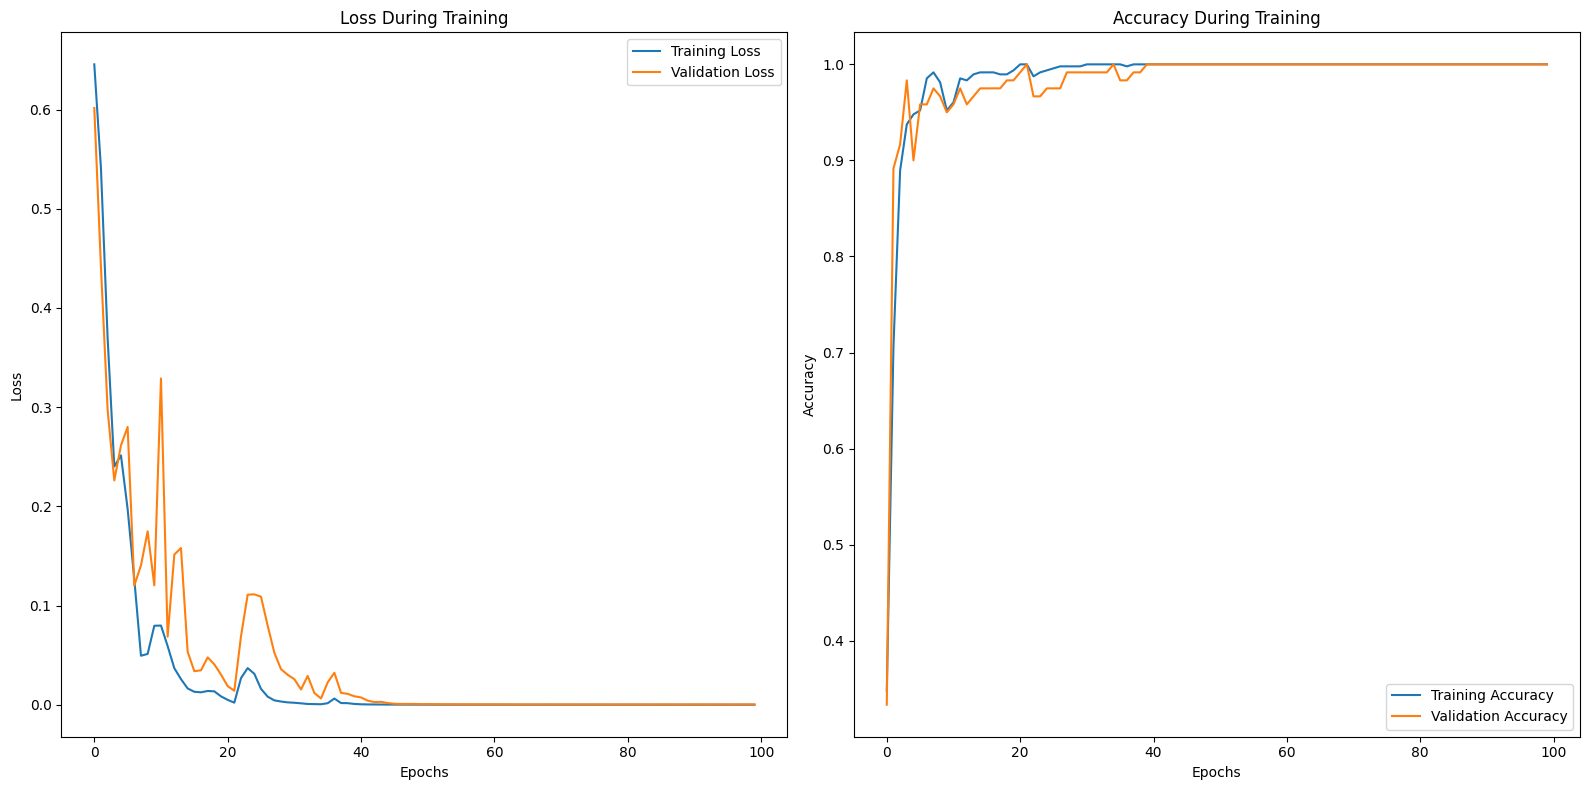

In [26]:
# Plot the loss and accuracy graphs together
plt.figure(figsize=(16, 8))

# Plot the loss graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
res = model.predict(X_val)
# classes[np.argmax(res[4])]
print(np.argmax(res[5]))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
1


In [28]:
# yhat = model.predict(X_test)
# ytrue = y_test

# yhat = (yhat > 0.5).astype(int)

# confusion_matrix(y_test, yhat)

In [29]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [30]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7
frame_counter = 0  # Khởi tạo biến đếm

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        
        frame_counter += 1  # Tăng biến đếm lên mỗi khi đọc khung hình
        if frame_counter % 3 != 0:  # Chỉ xử lý mỗi khung hình thứ 3 (tùy chỉnh)
            continue

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        keypoints = keypoints.flatten()
        # print(keypoints.shape)
        
        sequence.append(keypoints)
        sequence = sequence[-15:]
        
        if len(sequence) == 15:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(classes[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            # SendData(actions[np.argmax(res)])  

            # Viz probabilities
            image = prob_viz(res, classes, image, colors)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

d:\Phong\Coding\HandTracking\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
idle
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
idle
<c

In [31]:
model.save('interaction.keras')